# Abalone Shell Data: Exploring the Data

<br />
<br />
<br />

### Table of Contents

* Introduction
* Exporing the Data with Distributions
* Infants vs Adults
* Variable Transforms
* Identifying Outliers
* Functional Data Loading and Cleaning

<br />
<br />
<br />

## Introduction

This notebook explores a data set about abalones, which are essentially sea snails. Specifically, the data set describes several physical characteristics of abalones, and then gives a number of rings found in the shell. Counting rings is time-consuming and difficult, providing a motive to build a machine-learning algorithm capable of predicting the number of rings from other physical characteristics.

In this notebook, we'll explore the abalone shell data, examine distributions, and figure out first steps toward modeling the data and making predictions.

Start by importing libraries:

In [1]:
%matplotlib inline

# ml
from sklearn import linear_model, svm

# numbers
import numpy as np
import pandas as pd

# stats
import statsmodels.api as sm
import scipy.stats as stats

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# utils
import os, re

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Now grab the data from the `abalone/` directory:

In [2]:
# List data files
os.listdir('abalone/')

['.DS_Store', 'Dataset.data', 'Dataset.spec', 'rings', 'Source']

In [3]:
# x data labels
xnlabs = ['Sex']
xqlabs = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
xlabs = xnlabs + xqlabs

# y data labels
ylabs = ['Rings']

# data
df = pd.read_csv('abalone/Dataset.data', header=None, sep=' ', names=xlabs+ylabs)

train_df = df[:3000]
test_df = df[3000:]

In [4]:
# Czech it out
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null object
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole weight      4177 non-null float64
Shucked weight    4177 non-null float64
Viscera weight    4177 non-null float64
Shell weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


## Exploring the Data with Distributions

Start exploring the data by plotting some histograms of different quantities. Once we do that, we'll get a better idea of how they are distributed amongst the population of abalones sampled for this data set.

/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


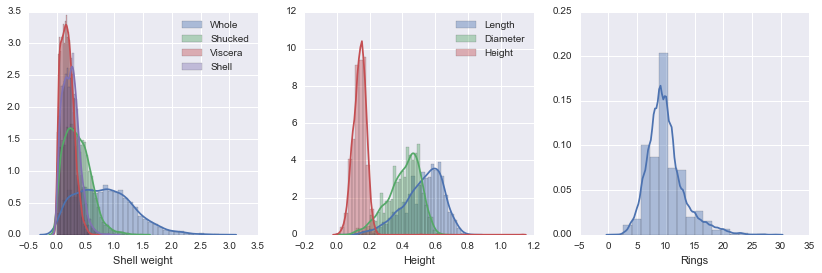

In [5]:
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

# Plot weight information
sns.distplot(df['Whole weight'],   label='Whole',   ax=ax1)
sns.distplot(df['Shucked weight'], label='Shucked', ax=ax1)
sns.distplot(df['Viscera weight'], label='Viscera', ax=ax1)
sns.distplot(df['Shell weight'],   label='Shell',   ax=ax1)
ax1.legend()

# Plot growth information
sns.distplot(df['Length'],   label='Length', ax=ax2)
sns.distplot(df['Diameter'], label='Diameter', ax=ax2)
sns.distplot(df['Height'],   label='Height', ax=ax2)
ax2.legend()

# Plot system response
sns.distplot(df['Rings'], bins=18, ax=ax3)

## Infants vs Adults

It is worth noting that we also have a "Sex" column that indicates whether the abalone is a male, a female, or an infant. We would expect infants to be significantly different from adults, so we'll split the data into the infant and adult groups, and look at histograms for each.

In [6]:
inf_df = df[df['Sex']=='I']
ni_df  = df[df['Sex']<>'I']

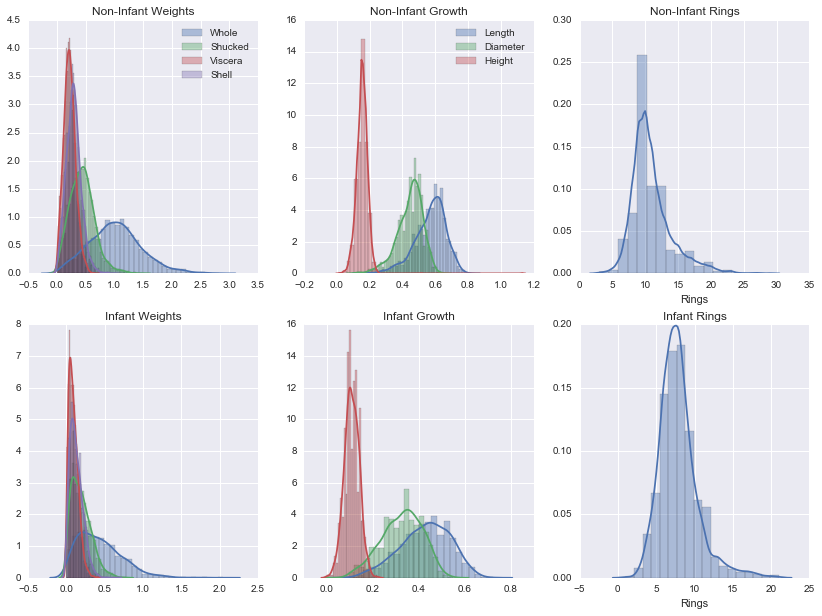

In [7]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

# Non infant weight info
sns.distplot(ni_df['Whole weight'],   label='Whole',   ax=ax1)
sns.distplot(ni_df['Shucked weight'], label='Shucked', ax=ax1)
sns.distplot(ni_df['Viscera weight'], label='Viscera', ax=ax1)
sns.distplot(ni_df['Shell weight'],   label='Shell',   ax=ax1)
ax1.legend()
ax1.set_title('Non-Infant Weights')


# Infant weight info
sns.distplot(inf_df['Whole weight'],   label='Whole',   ax=ax4)
sns.distplot(inf_df['Shucked weight'], label='Shucked', ax=ax4)
sns.distplot(inf_df['Viscera weight'], label='Viscera', ax=ax4)
sns.distplot(inf_df['Shell weight'],   label='Shell',   ax=ax4)
ax4.set_title('Infant Weights')


# Non-infant growth
sns.distplot(ni_df['Length'],   label='Length',   ax=ax2)
sns.distplot(ni_df['Diameter'], label='Diameter', ax=ax2)
sns.distplot(ni_df['Height'],   label='Height',   ax=ax2)
ax2.set_title('Non-Infant Growth')
ax2.legend()


# Infant growth
sns.distplot(inf_df['Length'],   label='Length',   ax=ax5)
sns.distplot(inf_df['Diameter'], label='Diameter', ax=ax5)
sns.distplot(inf_df['Height'],   label='Height',   ax=ax5)
ax5.set_title('Infant Growth')


# Plot system response
sns.distplot(ni_df['Rings'], bins=18, ax=ax3)
ax3.set_title('Non-Infant Rings')

sns.distplot(inf_df['Rings'], bins=18, ax=ax6)
ax6.set_title('Infant Rings')


ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('Rings')
ax4.set_xlabel('')
ax5.set_xlabel('')
ax6.set_xlabel('Rings')

Here are a few pieces of information we can glean from these distributions.

Weight distributions: 
* Whole weight has large variance compared to other weight factors, since it is integrating multiple weights.
* Whole weight is therefore unlikely to correlate as strongly as other weight variables.
* Shell weight and viscera weight appear to be the two quantities that best reflect the size of the organism.

Length, height, and diameter distribution:
* The length and diameter are both slightly negatively skewed. A skewed distribution indicates a natural upper limit on the quantity, which would be expected for quantities related to size.
* Infant and non-infant heights have very similar distributions
* Infant weights and lengths have smoother distributions with lower means and higher variances than the adult weight and length distributions.

Infant vs. adult:
* Infants have measurements with smaller means and higher variance than adults. 
* A model that makes predictions about the number of rings in infant shells will therefore have greater uncertainty and need to be more robust.
* A good starting point is to build a model that does not include infants, reducing variability in the population.


## Variable Transforms

We can also explore variable transforms to see if there is a more appropriate way to look at the input parameters. Here, we try taking the log or the exponential of a quantity:

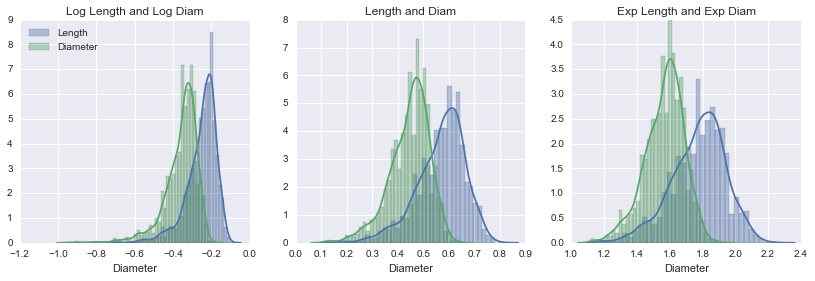

In [8]:
fig = plt.figure(figsize=(14,4))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.distplot(ni_df['Length'].apply(lambda x : np.log10(x)),   label='Length',   ax=ax1)
sns.distplot(ni_df['Diameter'].apply(lambda x : np.log10(x)), label='Diameter', ax=ax1)
ax1.set_title('Log Length and Log Diam')

sns.distplot(ni_df['Length'],   label='Length',   ax=ax2)
sns.distplot(ni_df['Diameter'], label='Diameter', ax=ax2)
ax2.set_title('Length and Diam')

sns.distplot(ni_df['Length'].apply(lambda x : np.exp(x)),   label='Length',   ax=ax3)
sns.distplot(ni_df['Diameter'].apply(lambda x : np.exp(x)), label='Diameter', ax=ax3)
ax3.set_title('Exp Length and Exp Diam')
ax1.legend(loc='best')

plt.show()

None of these distributions indicate that any particular transform would work better than the original quantity, so we'll leave height and diameter alone for now.

# Variable Combinations: Volume

If we look at how different variables correlate with one another, it may be possible to find a useful combination of variables.

For example, suppose we want to correlate the measured dimensions (height, length, and diameter) to the weight of the organism. Because height, length, and diameter all have units of length, the product of all three of these would give a quantity with units of length cubed, or volume. This approximate volume of the orgnaism should correlate with the weight of the organism - the slope of volume (x) vs. weight (y) would have a slope equal to the density.

Therefore, for an abalone, the volume is proportional to the length times diameter times height,

$$
V \sim L \times D \times H
$$

Looking at abalone shells, they are shaped like an oval bowl, with the height indicating the depth of the bowl. The shell's circular area can be computed from the area of an ellipse, which is $\pi a b$, where $a$ and $b$ are the major and minor axes. In the case of an abalone the major axis is proportional to the length, while the minor axis is proportional to the diameter.

In [9]:
ni_df = ni_df[ni_df['Height']>0]
inf_df = inf_df[inf_df['Height']>0]

In [10]:
ni_df.loc[:,'Volume'] = ni_df['Length'].values*ni_df['Diameter'].values*ni_df['Height'].values
inf_df.loc[:,'Volume'] = inf_df['Length'].values*inf_df['Diameter'].values*inf_df['Height'].values

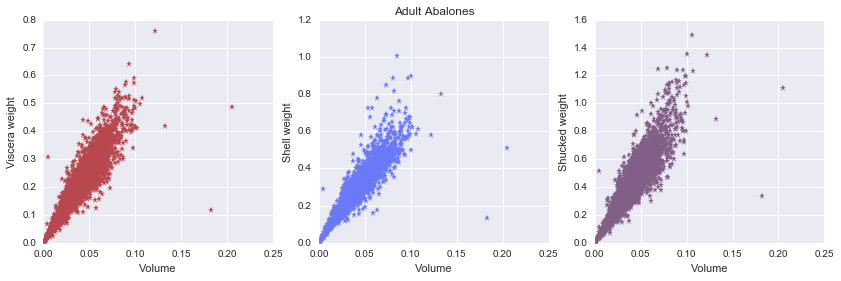

In [11]:
fig = plt.figure(figsize=(14,4))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(ni_df['Volume'], ni_df['Viscera weight'],'b*', color=sns.xkcd_rgb['dusty red'])
ax2.plot(ni_df['Volume'], ni_df['Shell weight'],'g*',   color=sns.xkcd_rgb['cornflower'])
ax3.plot(ni_df['Volume'], ni_df['Shucked weight'],'*',  color=sns.xkcd_rgb['dusty purple'])

ax1.set_xlabel('Volume')
ax2.set_xlabel('Volume')
ax3.set_xlabel('Volume')

ax1.set_ylabel('Viscera weight')
ax2.set_ylabel('Shell weight')
ax3.set_ylabel('Shucked weight')

ax2.set_title('Adult Abalones')

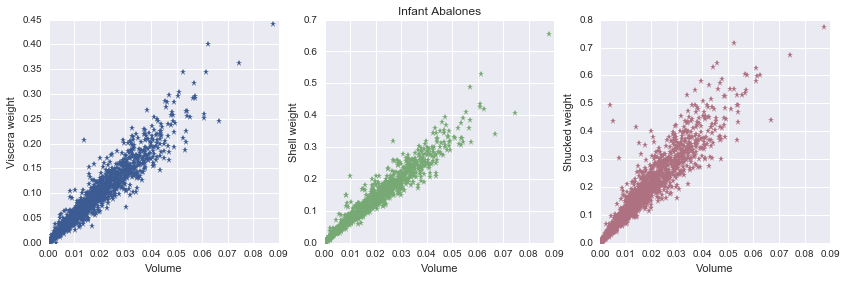

In [12]:
fig = plt.figure(figsize=(14,4))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(inf_df['Volume'], inf_df['Viscera weight'],'b*', color=sns.xkcd_rgb['denim blue'])
ax2.plot(inf_df['Volume'], inf_df['Shell weight'],'g*',   color=sns.xkcd_rgb['dusty green'])
ax3.plot(inf_df['Volume'], inf_df['Shucked weight'],'*',  color=sns.xkcd_rgb['mauve'])

ax1.set_xlabel('Volume')
ax2.set_xlabel('Volume')
ax3.set_xlabel('Volume')

ax1.set_ylabel('Viscera weight')
ax2.set_ylabel('Shell weight')
ax3.set_ylabel('Shucked weight')

ax2.set_title('Infant Abalones')

From the plots above, it looks like adult abalones have a strong correlation between the "volume" and the viscera weight. Infant abalones, on the other hand, have a strong correlation between the volume and the shell weight. 

## Identifying Outliers

The plots above can help to identify outliers - abalones whose volume is abnormally high for their viscera or shell weights, or vice-versa. (It appears some abalones have extremely small volumes.)

If we regress the volume versus viscera weight, we'll get a line. If we then compute the residuals from this linear model, we can identify the major outliers, and use those to prune problematic points.

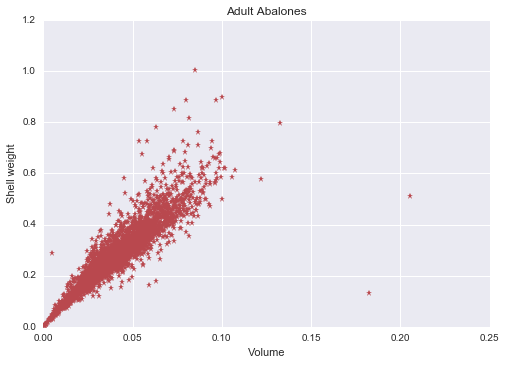

In [13]:
plt.plot(ni_df['Volume'], ni_df['Shell weight'],'b*', color=sns.xkcd_rgb['dusty red'])
plt.xlabel('Volume')
plt.ylabel('Shell weight')
plt.title('Adult Abalones')
plt.show()

In [14]:
X = ni_df['Volume']
Y = ni_df['Shell weight']
lin = sm.OLS(Y,X).fit()
lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Shell weight   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 8.218e+04
Date:                Sat, 07 Jan 2017   Prob (F-statistic):               0.00
Time:                        12:57:53   Log-Likelihood:                 4042.7
No. Observations:                2835   AIC:                            -8083.
Df Residuals:                    2834   BIC:                            -8078.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Volume         6.6696      0.023    286.677      0.000         6.624     6.715
==============================================================================
Omnibus:                     2220.903   Durbin-Watson:                   1.572
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           530894.304
Skew:                          -2.755   Prob(JB):                         0.00
Kurtosis:                      69.813   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
Yhat = lin.predict(ni_df['Volume'])
ni_df.loc[:,'Predicted shell weight'] = Yhat
ni_df.loc[:,'Residual'] = Y - Yhat
ni_df.loc[:,'MSE'] = (Y - Yhat)**2

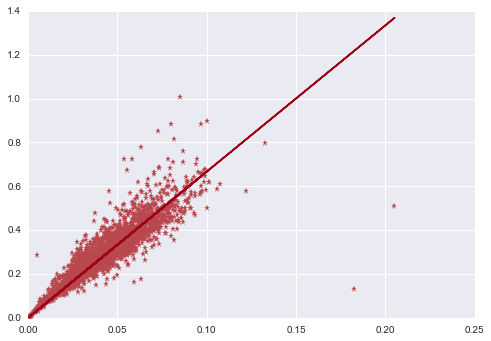

In [16]:
plt.plot(ni_df['Volume'], ni_df['Shell weight'],'*', color=sns.xkcd_rgb['dusty red'])
plt.plot(ni_df['Volume'], Yhat,'-', color=sns.xkcd_rgb['carmine'])
plt.show()

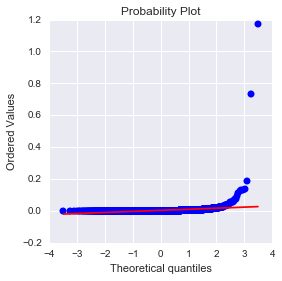

In [17]:
MSE = ni_df['MSE']
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
stats.probplot(MSE, dist='norm', plot=ax)
plt.show()

In [18]:
ni_df.sort_values('MSE',ascending=False).head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Volume,Predicted shell weight,Residual,MSE
2051,F,0.455,0.355,1.130,0.594,0.3320,0.1160,0.1335,8,0.182523,1.217351,-1.083851,1.174733
1417,M,0.705,0.565,0.515,2.210,1.1075,0.4865,0.5120,10,0.205137,1.368177,-0.856177,0.733040
163,F,0.725,0.560,0.210,2.141,0.6500,0.3980,1.0050,18,0.085260,0.568647,0.436353,0.190404
2157,M,0.620,0.495,0.175,1.806,0.6430,0.3285,0.7250,17,0.053707,0.358206,0.366794,0.134538
166,F,0.725,0.575,0.175,2.124,0.7650,0.4515,0.8500,20,0.072953,0.486566,0.363434,0.132084


In [19]:
thresh = 0.5
new_ni_df = ni_df[ni_df['MSE'] < thresh]

In [20]:
records_removed = len(ni_df) - len(new_ni_df)
print "Number of data points removed: %d"%(records_removed)
print "%0.1f%% of data was removed"%((float(records_removed)/len(df))*100)

Number of data points removed: 2
0.0% of data was removed


We can also do the same thing with data about infant abalones - removing outliers.

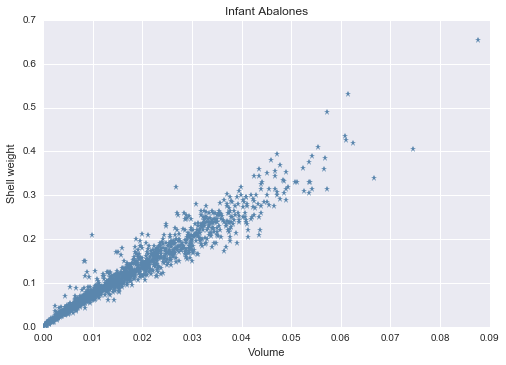

In [21]:
plt.plot(inf_df['Volume'], inf_df['Shell weight'],'b*', color=sns.xkcd_rgb['dusty blue'])
plt.xlabel('Volume')
plt.ylabel('Shell weight')
plt.title('Infant Abalones')
plt.show()

In [22]:
X = inf_df['Volume']
Y = inf_df['Shell weight']
lin2 = sm.OLS(Y,X).fit()
lin2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Shell weight   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 6.885e+04
Date:                Sat, 07 Jan 2017   Prob (F-statistic):               0.00
Time:                        12:57:55   Log-Likelihood:                 3262.3
No. Observations:                1340   AIC:                            -6523.
Df Residuals:                    1339   BIC:                            -6517.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Volume         6.8737      0.026    262.385      0.000         6.822     6.925
==============================================================================
Omnibus:                      204.006   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2461.786
Skew:                           0.256   Prob(JB):                         0.00
Kurtosis:                       9.620   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
Yhat = lin2.predict(inf_df['Volume'])
inf_df.loc[:,'Predicted shell weight'] = Yhat
inf_df.loc[:,'Residual'] = Y - Yhat
inf_df.loc[:,'MSE'] = (Y - Yhat)**2

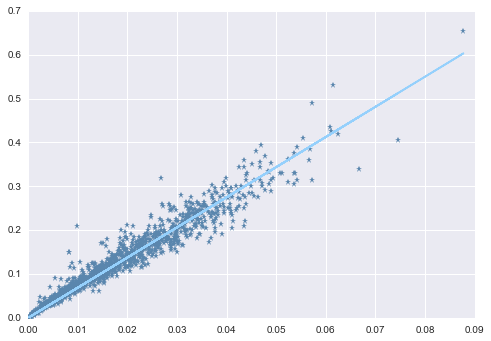

In [24]:
plt.plot(inf_df['Volume'], inf_df['Shell weight'],'*', color=sns.xkcd_rgb['dusty blue'])
plt.plot(inf_df['Volume'], Yhat,'-', color=sns.xkcd_rgb['light blue'])
plt.show()

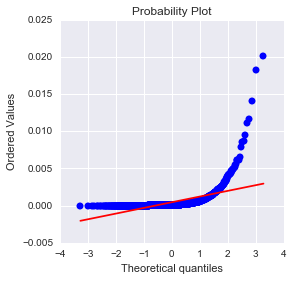

In [25]:
MSE = inf_df['MSE']
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
stats.probplot(MSE, dist='norm', plot=ax)
plt.show()

In [26]:
inf_df.sort_values('MSE',ascending=False).head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Volume,Predicted shell weight,Residual,MSE
3814,I,0.380,0.275,0.095,0.2425,0.1060,0.0485,0.2100,6,0.009928,0.068239,0.141761,0.020096
1777,I,0.485,0.345,0.160,0.8690,0.3085,0.1850,0.3190,9,0.026772,0.184024,0.134976,0.018219
510,I,0.680,0.530,0.185,1.1095,0.4390,0.2450,0.3400,10,0.066674,0.458299,-0.118299,0.013995
660,I,0.650,0.525,0.180,1.6260,0.5970,0.3445,0.5300,18,0.061425,0.422219,0.107781,0.011617
2537,I,0.660,0.525,0.215,1.7860,0.6725,0.3615,0.4065,11,0.074498,0.512076,-0.105576,0.011146


In [27]:
thresh = 0.05
new_inf_df = inf_df[inf_df['MSE'] < thresh]
records_removed = len(inf_df) - len(new_inf_df)
print "Number of data points removed: %d"%(records_removed)
print "%0.2f%% of data was removed"%((float(records_removed)/len(df))*100)

Number of data points removed: 0
0.00% of data was removed


It is interesting to note that the linear regression of "volume" versus predicted shell weight has nearly the same slope between the infants and adults - 6.87 for infants, 6.69 for adults. 

While the quantile plot shows that the trendline is not really linear, the fact that both infant and adult abalones had similar slopes is an indication that the general upward trend holds true across abalones of different ages, and the rate of growth does not slow down once the abalones reach adulthood.

# Functional Data Loading and Cleaning

We can wrap all of this functionality (loading the data, fitting volume versus weight, and removing outliers) in a function that can be used in other notebooks.

In [28]:
def abalone_load(data_file, infant=False):
    # x data labels
    xnlabs = ['Sex']
    xqlabs = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
    xlabs = xnlabs + xqlabs

    # y data labels
    ylabs = ['Rings']

    # data
    df = pd.read_csv(data_file, header=None, sep=' ', names=xlabs+ylabs)
    
    if(infant):
        new_df = df[ df['Sex']=='I' ]
    else:
        new_df = df[ df['Sex']<>'I' ]
    return new_df

def infant_abalone_load(data_file):
    return abalone_load(data_file,True)

def adult_abalone_load(data_file):
    return abalone_load(data_file,False)

def abalone_removeoutliers(df,mse_tol,verbose=False):
    df.loc[:,'Volume'] = df['Length'].values*df['Diameter'].values*df['Height'].values

    X = df['Volume']
    Y = df['Shell weight']
    lin = sm.OLS(Y,X).fit()

    Yhat = lin.predict(df['Volume'])
    df.loc[:,'Predicted shell weight'] = Yhat
    df.loc[:,'Residual'] = Y - Yhat
    df.loc[:,'MSE'] = (Y - Yhat)**2
    MSE = df['MSE']

    thresh = 0.5
    new_df = df[df['MSE'] < thresh]
    records_removed = len(df) - len(new_df)
    
    if(verbose):
        print "Number of data points removed: %d"%(records_removed)
        print "%0.2f%% of data was removed"%((float(records_removed)/len(df))*100)
    
    del df['Predicted shell weight']
    del df['Residual']
    del df['MSE']
    
    return df

def infant_abalone_removeoutliers(df):
    return abalone_removeoutliers(df,0.5)
    
def adult_abalone_removeoutliers(df):
    return abalone_removeoutliers(df,1.0)

In [29]:
my_inf_df = infant_abalone_removeoutliers(infant_abalone_load('abalone/Dataset.data'))